## 1. Configuation of Processor (CPU/GPU)

In [48]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import os, PIL, pathlib
# import numpy as np
# print(np.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [49]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

classNames = [str(i) for i in range(10)]

print("className:", classNames)
print("Size training set:", len(train_dataset))
print("Size test set:", len(test_dataset))

batch_size = 100

train_lr=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=1)
test_lr=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True,num_workers=1)

for X,y in test_lr:
    print("X:",X.shape)
    print("y:",y.shape,y.dtype)
    break

className: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Size training set: 60000
Size test set: 10000
X: torch.Size([100, 1, 28, 28])
y: torch.Size([100]) torch.int64


In [50]:
import torch.nn.functional as F

class ConvNetwork(nn.Module):
    def __init__ (self):
        super(ConvNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3, padding=0)
        self.fc1 = nn.Linear(32 * 2 * 2, len(classNames))

    def forward(self, x):
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.bn2(self.conv2(x)))
        x=self.pool(x)
        x=F.relu(self.bn3(self.conv3(x)))
        x=self.pool(x)
        x = x.view(x.size(0), -1)

        x=self.fc1(x)
        return x
    
model=ConvNetwork().to(device)
model


ConvNetwork(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

In [51]:
loss_function=nn.CrossEntropyLoss()
learn_rate=1e-4
opt=torch.optim.SGD(model.parameters(),lr=learn_rate)

In [52]:
def train(dataloader, model, loss_fn, optimizer):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)

    train_loss, train_acc=0,0

    for X,y in dataloader:
        X,y=X.to(device),y.to(device)

        pred=model(X)
        loss=loss_fn(pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        correct=(pred.argmax(1)==y).type(torch.float).sum().item()
        train_acc+=correct

    train_loss/=num_batches
    train_acc/=size
        
    return train_loss, train_acc

In [53]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)

            pred = model(imgs)
            loss = loss_fn(pred, target)  

            test_loss += loss.item()      
            correct = (pred.argmax(1) == target).type(torch.float).sum().item()
            test_acc += correct

    test_loss /= num_batches
    test_acc /= size

    return test_loss, test_acc


In [54]:
epochs=5
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

for epoch in range(epochs):
    model.train()
    epoch_train_loss, epoch_train_acc=train(train_lr, model, loss_function, opt)

    model.eval()
    epoch_test_loss, epoch_test_acc=test(test_lr, model, loss_function)

    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    template="Epoch {}/{}: Train Loss {:.4f}, Train Acc {:.4f}, Test Loss {:.4f}, Test Acc {:.4f}"
    print(template.format(epoch+1, epochs, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc))
print("Done!")

Epoch 1/5: Train Loss 2.4007, Train Acc 0.1470, Test Loss 2.2421, Test Acc 0.2460
Epoch 2/5: Train Loss 2.1403, Train Acc 0.2953, Test Loss 2.0432, Test Acc 0.3668
Epoch 3/5: Train Loss 1.9849, Train Acc 0.4150, Test Loss 1.9152, Test Acc 0.4839
Epoch 4/5: Train Loss 1.8700, Train Acc 0.5153, Test Loss 1.8078, Test Acc 0.5648
Epoch 5/5: Train Loss 1.7688, Train Acc 0.5844, Test Loss 1.7084, Test Acc 0.6286
Done!


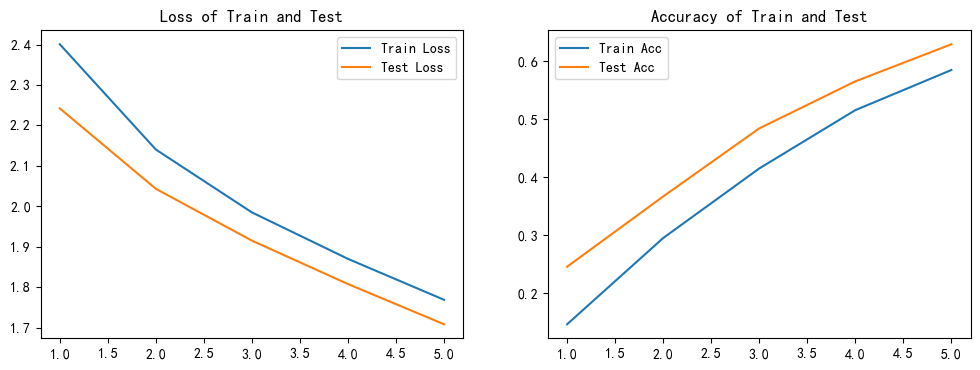

In [55]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.dpi']=100

epochs_range=range(1,epochs+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range,train_loss,label='Train Loss')
plt.plot(epochs_range,test_loss,label='Test Loss')
plt.legend()
plt.title('Loss of Train and Test')

plt.subplot(1,2,2)
plt.plot(epochs_range,train_acc,label='Train Acc')
plt.plot(epochs_range,test_acc,label='Test Acc')
plt.legend()
plt.title('Accuracy of Train and Test')
plt.show()